# EarlySign Tutorial: Group Sequential Testing (Two-Proportions) with a Ledger-Centric Design

This tutorial demonstrates how to run a group sequential test (GST) for a two-proportions A/B experiment using a **ledger-centric** architecture.

We will:
1. Initialize a Polars-backed ledger.
2. Iteratively append observation batches (simulated).
3. Update a Wald Z statistic and a Lan–DeMets (OBF/Pocock) boundary per look.
4. Emit a stop signal if the boundary is crossed.
5. Summarize and visualize progress.

## Requirements

```bash
pip install earlysign[examples]
```

In [1]:
import numpy as np

# New business-oriented facade API - all A/B testing functionality in one place
from earlysign.api.ab_test import interim_analysis
from earlysign.runtime.runners import SequentialRunner
import ibis
from earlysign.core.ledger import Ledger, create_test_connection

# Updated imports using ADR-002 structure
from earlysign.core.ledger import Namespace
from earlysign.stats.common.group_sequential import nominal_alpha_increments
from earlysign.stats.schemes.two_proportions.group_sequential import (
    WaldZStatistic,
    LanDeMetsBoundary,
    PeekSignaler,
)
from earlysign.reporting.generic import LedgerReporter
from earlysign.reporting.two_proportions import TwoPropGSTReporter

np.set_printoptions(suppress=True)

## Configure the experiment

We plan 4 looks, a two-sided alpha of 0.05, and O'Brien–Fleming (OBF) spending. We also specify a target fixed-sample size per arm just for this simulation example.


In [2]:
import math
from datetime import datetime, timezone

# Experiment configuration
exp_id = "exp#loop-demo"
alpha_total = 0.05
looks = 4
spending = "conservative"  # "conservative" (OBF) or "aggressive" (Pocock)

# Step 1: Create a business-oriented experiment using the facade API
# This uses familiar terminology: "interim_analysis" instead of "group_sequential_test"
experiment = interim_analysis(
    experiment_id=exp_id, alpha=alpha_total, looks=looks, spending=spending
)

# Step 2: Create a runner with your chosen backend
# The runner handles execution while the module defines the experiment
conn = create_test_connection("duckdb")  # Use DuckDB instead of Polars
ledger = Ledger(conn, exp_id)
runner = SequentialRunner(experiment, ledger)

print(f"📦 Experiment: {experiment.__class__.__name__}")
print(f"🏃 Runner: {runner.__class__.__name__}")
print(f"⚙️  Backend: {type(runner._ledger).__name__}")

# Simulation parameters (for demonstration)
n_per_arm = 400
t_grid = tuple((i + 1) / looks for i in range(looks))  # (0.25, 0.5, 0.75, 1.0)
targets = [math.ceil(n_per_arm * t) for t in t_grid]

# Ground-truth rates (for simulation)
pA_true, pB_true = 0.70, 0.80
rng = np.random.default_rng(7)

print(f"\n🎯 Experiment Design:")
print(f"   Method: Interim Analysis with {spending} spending")
print(f"   Alpha: {alpha_total}, Looks: {looks}")
print(f"   Targets per look: {targets}")
print(f"   True rates: Group A = {pA_true:.0%}, Group B = {pB_true:.0%}")

# The experiment automatically registers the design when setup() is called by the runner
summary = runner.get_summary()
print(f"\n✅ Setup complete. Components: {summary['components']}")

📦 Experiment: TwoPropGSTTemplate
🏃 Runner: SequentialRunner
⚙️  Backend: Ledger

🎯 Experiment Design:
   Method: Interim Analysis with conservative spending
   Alpha: 0.05, Looks: 4
   Targets per look: [100, 200, 300, 400]
   True rates: Group A = 70%, Group B = 80%

✅ Setup complete. Components: ['observation', 'statistic', 'criteria', 'signaler']


## Run the sequential procedure in a loop

For each look:
1. Append a new observation batch to the ledger.
2. Update the Wald Z statistic.
3. Update the Lan–DeMets (OBF) boundary at the current information fraction.
4. Let the signaler check whether to **stop early**.

In [3]:
cum_nA = cum_nB = cum_mA = cum_mB = 0
stopped = False
stop_look = None

for i, t in enumerate(t_grid, start=1):
    # Target sample size up to this look
    target = targets[i - 1]
    add_nA = max(target - cum_nA, 0)
    add_nB = max(target - cum_nB, 0)
    add_mA = int(rng.binomial(add_nA, pA_true)) if add_nA > 0 else 0
    add_mB = int(rng.binomial(add_nB, pB_true)) if add_nB > 0 else 0

    cum_nA += add_nA
    cum_nB += add_nB
    cum_mA += add_mA
    cum_mB += add_mB

    print(f"\n=== Look {i} ===")
    print(f"Adding: Group A {add_mA}/{add_nA}, Group B {add_mB}/{add_nB}")
    print(
        f"Cumulative: Group A {cum_mA}/{cum_nA} ({cum_mA/cum_nA:.1%}), Group B {cum_mB}/{cum_nB} ({cum_mB/cum_nB:.1%})"
    )

    # 1) Add observations using the modular interface
    runner.add_observations(
        group_a_success=add_mA,
        group_a_total=add_nA,
        group_b_success=add_mB,
        group_b_total=add_nB,
    )

    # 2) Run analysis - the module coordinates all components internally
    result = runner.analyze()

    print(f"Z-statistic: {result.statistic_value:.3f}")
    if result.threshold_value:
        print(f"Boundary: ±{result.threshold_value:.3f}")

    # Handle information_fraction formatting safely
    info_frac = result.additional_metrics.get("information_fraction", "N/A")
    if isinstance(info_frac, str):
        print(f"Information fraction: {info_frac}")
    else:
        print(f"Information fraction: {info_frac:.3f}")

    print(f"Decision: {'🛑 STOP' if result.should_stop else '✅ Continue'}")

    if result.should_stop:
        stopped = True
        stop_look = i
        break

print(f"\n=== Final Result ===")
print(f"Stopped: {stopped}, Stop look: {stop_look}")
print(f"Final sample size: {cum_nA + cum_nB}")

# Get final summary from the runner
final_summary = runner.get_summary()
print(f"Total looks executed: {final_summary['total_looks']}")

# Access the underlying ledger for advanced operations (if needed)
L = runner._ledger


=== Look 1 ===
Adding: Group A 64/100, Group B 82/100
Cumulative: Group A 64/100 (64.0%), Group B 82/100 (82.0%)
Z-statistic: 2.928
Boundary: ±1.960
Information fraction: N/A
Decision: 🛑 STOP

=== Final Result ===
Stopped: True, Stop look: 1
Final sample size: 200
Total looks executed: 1


## Inspect the ledger
We can show a generic view of the ledger and a method-specific progress table.

In [4]:
from IPython.display import display

gen = LedgerReporter(L)  # Pass the Ledger object directly
gen_table = gen.ledger_table().execute()  # Execute to get actual data
gen_counts = (
    gen.namespace_kind_counts().execute()
)  # Use correct method name and execute
display(gen_table)
display(gen_counts)

,uuid,ledger_name,time_index,ts,namespace,kind,entity,snapshot_id,tag,payload_type,payload,earlysign_version
0,a4446724-0971-42a8-84d5-136b3f52b53b,exp#loop-demo,t0,2025-09-13 16:49:55.988400,Namespace.DESIGN,experiment_design,exp#loop-demo#design,design,,gst_design,"{'alpha_total': 0.05, 'looks': 4, 'method': 'g...",0.2.0.post30
1,7840102d-3c40-4f27-abc0-827d0a0fbfeb,exp#loop-demo,t1,2025-09-13 16:49:56.194744,Namespace.OBS,observation,exp#loop-demo#look-1,look-1,obs:generic,TwoPropObsBatch,"{'mA': 64, 'mB': 82, 'nA': 100, 'nB': 100}",0.2.0.post30
2,f50fd7ad-e737-47b0-9d75-9fd346e63cff,exp#loop-demo,t1,2025-09-13 16:49:56.204972,Namespace.STATS,updated,exp#loop-demo#look-1,look-1,stat:waldz,WaldZ,"{'mA': 64, 'mB': 82, 'nA': 100, 'nB': 100, 'pA...",0.2.0.post30
3,709a5e23-a678-4842-af69-29e9dc539724,exp#loop-demo,t1,2025-09-13 16:49:56.208040,Namespace.CRITERIA,updated,exp#loop-demo#look-1,look-1,crit:gst,GSTBoundary,"{'alpha_i': 0.05, 'info_time': 1.0, 'lower': -...",0.2.0.post30
4,6b072da2-05db-4690-b5c3-3ea93c9455fc,exp#loop-demo,t1,2025-09-13 16:49:56.229514,Namespace.SIGNALS,decision,exp#loop-demo#look-1,look-1,gst:decision,dict,"{'action': 'stop', 'pA_hat': 0.64, 'pB_hat': 0...",0.2.0.post30


,namespace,kind,count
0,Namespace.CRITERIA,updated,1
1,Namespace.DESIGN,experiment_design,1
2,Namespace.OBS,observation,1
3,Namespace.SIGNALS,decision,1
4,Namespace.STATS,updated,1


In [5]:
rep = TwoPropGSTReporter(L)  # Pass Ledger object directly
progress = rep.progress_table()
progress

r0 := DatabaseTable: ledger
  uuid              uuid
  ledger_name       string
  time_index        string
  ts                timestamp(6)
  namespace         string
  kind              string
  entity            string
  snapshot_id       string
  tag               string
  payload_type      string
  payload           json
  earlysign_version string

r1 := Filter[r0]
  r0.ledger_name == 'exp#loop-demo'

r2 := Filter[r1]
  r1.namespace == 'Namespace.STATS'
  r1.kind == 'updated'
  r1.payload_type == 'WaldZ'

r3 := Filter[r1]
  r1.namespace == 'Namespace.CRITERIA'
  r1.kind == 'updated'
  r1.payload_type == 'GSTBoundary'

r4 := Project[r3]
  time_index: r3.time_index
  upper:      Cast(JSONGetItem(r3.payload, index='upper'), to=float64)
  lower:      Cast(JSONGetItem(r3.payload, index='lower'), to=float64)
  t:          Cast(JSONGetItem(r3.payload, index='info_time'), to=float64)

r5 := Project[r2]
  time_index: r2.time_index
  ts:         r2.ts
  entity:     r2.entity
  look:       Cast(Coalesce([NullIf(Substring(r2.time_index, start=2), null_if_expr=''), '0']), to=int64)
  z:          Cast(JSONGetItem(r2.payload, index='z'), to=float64)
  nA:         Cast(JSONGetItem(r2.payload, index='nA'), to=int64)
  nB:         Cast(JSONGetItem(r2.payload, index='nB'), to=int64)
  mA:         Cast(JSONGetItem(r2.payload, index='mA'), to=int64)
  mB:         Cast(JSONGetItem(r2.payload, index='mB'), to=int64)

r6 := JoinChain[r5]
  JoinLink[left, r4]
    r5.time_index == r4.time_index
  values:
    time_index:       r5.time_index
    ts:               r5.ts
    entity:           r5.entity
    look:             r5.look
    z:                r5.z
    nA:               r5.nA
    nB:               r5.nB
    mA:               r5.mA
    mB:               r5.mB
    time_index_right: r4.time_index
    upper:            r4.upper
    lower:            r4.lower
    t:                r4.t

Sort[r6]
  asc r6.look

## Visualize Z and boundaries
A simple plot of the Wald Z trajectory and the symmetric boundaries across information fractions.

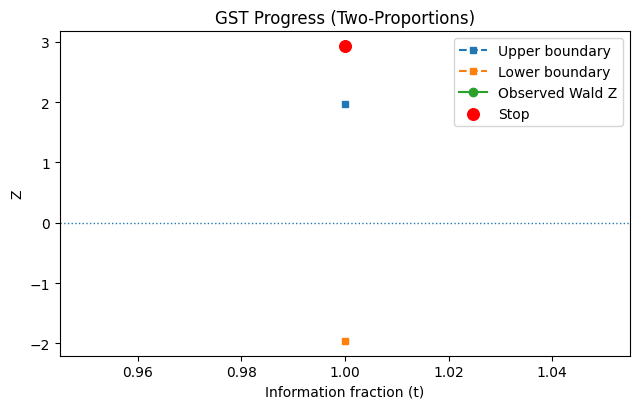

In [6]:
# If running in a notebook, this will render inline
rep.plot()

## Next steps
- Replace the simulated observation batches with your actual data source.
- Swap OBF with Pocock spending by setting `style="pocock"`.
- Extend the scheme to other data types or add additional criteria/signals.
- Persist the Polars ledger using sinks/sources in `earlysign.backends.polars.io`.

## Advanced: Creating Custom Experiment Modules

The modular architecture makes it easy to create **portable, shareable experiment definitions**. Here's how to create your own custom modules:

### 1. Custom Module Definition
Analysts can create their own modules by subclassing `ExperimentTemplate` or `TwoPropTemplate`

### 2. Data Ingestion Components
For complex data scenarios, you can still access the underlying ingestion components

### 3. Module Comparison
Compare different experiment designs using the `BatchRunner`